<h1><center> PPOL564 - Data Science I: Foundations </center><h1>
<h3><center> Lecture 17 <br><br><font color='grey'> Eigen Decompositions as Latent Variables </font></center></h3>

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings("ignore")

def download_data(git_loc,dest_name):
    '''
    Download data from Github and save to the notebook's working directory.
    '''
    req = requests.get(git_loc)
    with open(dest_name,"w") as file:
        for line in req.text:
            file.writelines(line)
            
download_data('https://raw.githubusercontent.com/edunford/ppol564/master/lectures/lecture_17/afg-security-survey-2008.csv',
              "afg-security-survey-2008.csv")

## Data

The Afghanistan Nationwide Quarterly Assessment Research (ANQAR) survey collects information from a subnational random sample of Afghan respondents from Sept. 2008 to May 2015 — resulting in a total of 32 survey waves. The survey gathers information on a variety of metrics, including for example, perceptions of the government, a respondent’s quality of life, the provision of services, and view on occupying forces in the country to name a few.

The ANQAR survey data randomly samples respondents from various administrative districts and provinces in Afghanistan across the relevant time period (see the ANQAR codebook for speciﬁc details on how the data was collected). There are a total of 426 districts where respondents are situated in 1 and 34 provinces housed in 7 broad regions. 

The following data contains aggregated responses for questions regarding security for each district sampled during the survey's initial wave around September 2008. 5 survey response questions (hereafter "items") are retained in total. These items are 


- **Q2**: How is the security situation in your mantaqa? Is it good, fair, or bad?
- **Q263**: How safe are the children in your village when they go to school and study in school? Are they completely safe, mostly safe, a little safe, a little unsafe, or very unsafe?
- **Q3**: Is security in your mantaqa better, the same or worse than it was 6 months ago? Is security in your mantaqa better, worse, or the same than it was 6 months ago?
- **Q4**: How safe do you feel traveling outside of your mantaqa during the day? Do you feel completely safe, mostly safe, a little safe, a little unsafe, or very unsafe?
- **Q5**: If you use roads in your district, how safe do you feel using the roads in your district? Do you feel completely safe, mostly safe, a little safe, a little unsafe, or very unsafe?

In addition, event data regarding the occurrence of violence within a Anfghan province is retained. The data on event occurrences was generated through reports of activity by the US army. 

In [2]:
data = pd.read_csv('afg-security-survey-2008.csv')
data.head()

,province,district,year,event_count,occurrence,Q2,Q263,Q3,Q4,Q5
0,1,100,2008,5,Violence,1.30,2.800000,1.421053,2.90,3.400000
1,1,101,2008,5,Violence,1.60,1.100000,1.600000,1.70,2.300000
2,1,102,2008,5,Violence,1.30,2.450000,1.350000,2.30,3.300000
3,1,103,2008,5,Violence,1.70,2.500000,1.400000,2.10,3.200000
4,1,104,2008,5,Violence,1.95,2.210526,1.473684,2.55,3.315789


### Exploring the Data: Correlation of Survey Items

In [3]:
cols = data.columns[data.columns.str.contains('Q')]
items = data[cols]
S = items.corr()
print("Correlation Table of Security Items")
S.round(2)

Correlation Table of Security Items


,Q2,Q263,Q3,Q4,Q5
Q2,1.00,0.72,0.79,0.75,0.73
Q263,0.72,1.00,0.59,0.87,0.85
Q3,0.79,0.59,1.00,0.65,0.61
Q4,0.75,0.87,0.65,1.00,0.89
Q5,0.73,0.85,0.61,0.89,1.00


### Eigendecomposition

As we saw last time, we can decompose a square matrix into a matrix of eigenvectors and eigenvalues. Here we will use our correlation matrix $\rho$

<br>
<br>

$$ \rho = \textbf{V}\Lambda\textbf{V}^{-1} $$

<br>
<br>

Where $\textbf{V}$ is a matrix of eigenvectors and $\Lambda$ is a diagonal matrix of eigenvalues.

<br>
<br>

When decomposing a covariance matrix, we are aiming to find the eigenvectors that maximum the variance of data. In a sense, the eigenvector with the largest eigenvalue tells most of the story in the data. What we are interested in is finding a single vector that broadly convey most of the information without having to use all of the data.  

In [4]:
evals,evecs = la.eig(S)
evals

array([3.98905314, 0.56343613, 0.19260065, 0.10359828, 0.15131179])

In [5]:
evecs

array([[-0.4454257 , -0.38499453,  0.80140783, -0.08423961,  0.06343761],
       [-0.45484691,  0.36993596,  0.00705231,  0.18808874, -0.78793056],
       [-0.40361606, -0.71679719, -0.5495099 ,  0.1227538 , -0.07915957],
       [-0.46876165,  0.27952722, -0.22500491, -0.77825698,  0.2140465 ],
       [-0.46050714,  0.35070346, -0.07146614,  0.58032223,  0.56838276]])

### Explained Variation

Proportion of Variation Explained

    Eigenvalue 1 accounts for 79.78% of the variance
    

    Eigenvalue 2 accounts for 11.27% of the variance
    

    Eigenvalue 3 accounts for 3.85% of the variance
    

    Eigenvalue 4 accounts for 2.07% of the variance
    

    Eigenvalue 5 accounts for 3.03% of the variance
    


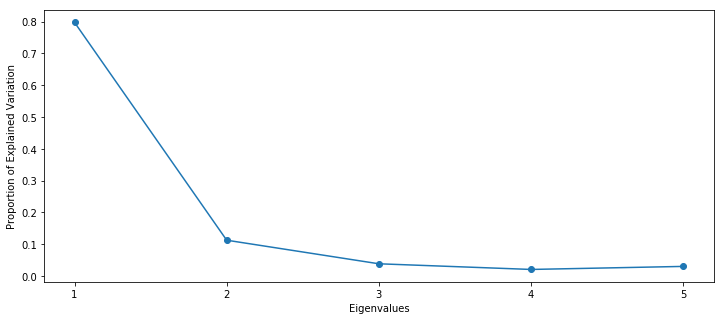

In [6]:
variance_explained = evals/sum(abs(evals))

# Print out variance figures
print('Proportion of Variation Explained')
for i,val in enumerate(variance_explained):
    print(f'''
    Eigenvalue {i+1} accounts for {round(val*100,2)}% of the variance
    ''')
    
# Plot figure
plt.figure(figsize=(12,5))
plt.plot(variance_explained,marker='o')
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel("Eigenvalues")
plt.ylabel("Proportion of Explained Variation")
plt.show()

### Generate Latent Scale (Projection)

We can now pick the eigenvectors that correspond with the largest eigenvalues and project our data onto them to generate a new scale. Again, all matrix multiplication is a transformation. Here we are using the eigenvectors as weights to project our observed data onto the eigvectors that most explain our data.

<br>
<br>

$$ \textbf{X}_{n\times p}\textbf{v}_{p\times 1}^* = \textbf{s}_{n\times 1}$$

<br>
<br>

where $\textbf{X}$ is our original ${n\times p}$ data matrix, $\textbf{v}^*$ is an eigen vector that corresponds with our largest eigenvalue, and $\textbf{s}$ is the resulting column vector with our projected scores for that eigenvector. 

In [7]:
data['threat'] = items.dot(evecs[:,0])
data['security'] = items.dot(evecs[:,1])

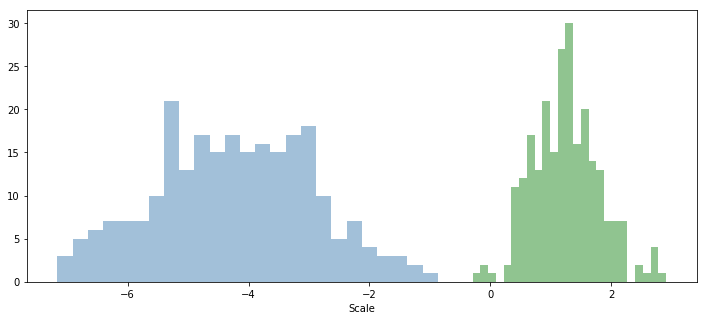

In [8]:
plt.figure(figsize=(12,5))
plt.hist(data['threat'],color="steelblue",
         bins=25,alpha=.5)
plt.hist(data['security'],color="forestgreen",
         bins=25,alpha=.5)
plt.xlabel('Scale')
plt.show()

#### Rescale Latent Scales

In [9]:
def standardize(x):
    '''
    Set mean equal to 0 and variance equal to 1
    '''
    return (x-np.mean(x))/np.std(x)

# Standardize Scales
data['threat'] = standardize(data['threat']) 
data['security'] = standardize(data['security']) 

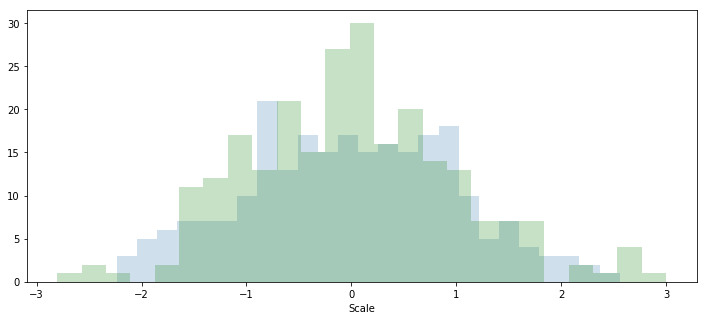

In [10]:
plt.figure(figsize=(12,5))
plt.hist(data['threat'],color="steelblue",
         bins=25,alpha=.25)
plt.hist(data['security'],color="forestgreen",
         bins=25,alpha=.25)
plt.xlabel('Scale')
plt.show()

#### Relationship between "security" and "threat" scales

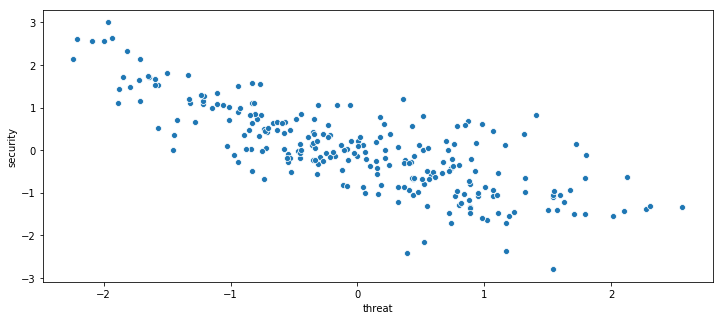

In [11]:
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='threat',y='security',data=data)

## Validation

Any scale of security/threat should be correlated with the actual occurrence of violence within a region. Let's explore our metrics to see if this behavior holds using the `event_count` and `occurrence` variables (drawn from the SIGACTS data)

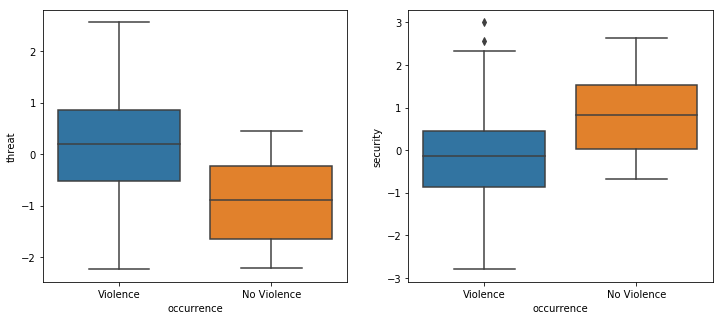

In [12]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
g = sns.boxplot(x='occurrence',y='threat',data=data,ax=axes[0])
g = sns.boxplot(x='occurrence',y='security',data=data,ax=axes[1])

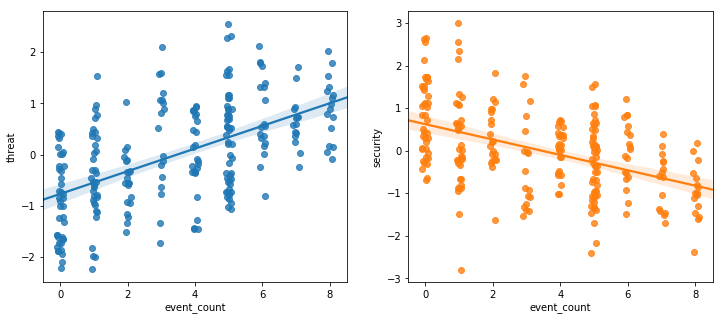

In [13]:
f, axes = plt.subplots(1, 2,figsize=(12,5))
g = sns.regplot(x='event_count',y='threat',data=data,x_jitter=.1,ax=axes[0])
g = sns.regplot(x='event_count',y='security',data=data,x_jitter=.1,ax=axes[1])